# Decision Trees and the Iterative Dichtomiser 3 (ID3) Algorithm
By Marco A. Peyrot for course 15-388, Carnegie Mellon University

![A decision tree.](decision_tree.png)
Image obtained from [source](https://littleml.files.wordpress.com/2013/04/traditional.png). _No rights over it owned_.

## Introduction

In this tutorial, you will learn about the Iterative Dichtomiser 3 (ID3) Algorithm through an interactive example. The tutorial is divided into sections that will lead you through all the necessary steps to use ID3; from data gathering to the application of the algorithm, to the final decision tree it returns.

### What is a decision tree?

A decision tree is a regression or classification model in the form of a tree (not strictly binary) that is used to determine if individual _predictor_ values will lead to a particular decision. Each branch in this data structure represents a possible choice between several alternatives, and each leaf node accounts for a decision. Therefore, it finds common usage in aiding decision making, where a decision is a product of traversing the tree from top to bottom. 

> A decision tree represents the learned functions obtained from approximating discrete-valued target functions.
> -- <cite>Tom M. Mitchell,  Machine Learning (1997)</cite>.

A decision tree learning algorithm involves processing some data set through some criteria (for example Gini impurity or entropy) to generate nodes. Non-leaf nodes will be processed further until only leaf nodes remain.

### What is the ID3 algorithm? 

The ID3 is a traditional _Decision Tree Learning Algorithm_ for creating decision trees based on some observable data. The algorithm was invented by Ross Quinlan in 1983 and operates by _dichtomizing_ (to divide or separate into two parts) data instances into branches recursively, hence the name. 

This algorithm uses a top-down greedy search to generate the decision tree. It is one of the simplest tree learning algorithms and serves as the predecessor for the C4.5 algorithm (click [here](http://saiconference.com/Downloads/SpecialIssueNo10/Paper_3-A_comparative_study_of_decision_tree_ID3_and_C4.5.pdf) to learn about this algorithm). It is often one of the first tree learning algorithms taught in machine learning courses because it makes the classification process self-evident.

There is a limitation to consider: it can only operate on discrete values for both predictors and targets; that is, it cannot operate on continuous data. There exist several modifications and improvements of the algorithm to cope with these limitations. However, they are out of scope for the present tutorial.

Without further delay, let's start!

In [1]:
import pandas as pd
import math
import graphviz as gv
from IPython.display import Image
from IPython.core.display import HTML
import numpy as np

# used to render the graphs in the center of the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

You may have to manually install with [pip](https://pypi.python.org/pypi/pip) the `Pandas`, `Graphviz`, and `IPython` modules before continuing with the tutorial.

## The training data set

For this tutorial, we will be using a training data set from the Kaggle website about global shark attacks. This data was collected as a CSV file and is located in the same directory as this notebook. The file can be downloaded from this [source](https://www.kaggle.com/teajay/global-shark-attacks). The contents of the archive are:

![A decision tree.](data_spec.jpg)

In this tutorial we will determine based on the information in this [website](http://www.theinertia.com/surf/10-shark-attack-beaches/), _upon which factors is it likely that a person will suffer an attack from a Bull or a Tiger shark?_ From this data our prediction label (y) will be the Species of Sharks. We will create a pandas `DataFrame` to hold this data and start processing it. Notice that some of this values are not discrete or irrelevant to the problem, so we must take them out of the Data Frame or classify them into categories.

The `get_target` function takes a label column and returns a `target` list that will be our prediction; in this case 1 for a Tiger and 0 for a Bull shark.

In [2]:
def get_target(df, target_name, pos_value):
    """ Given a DataFrame, create the target list for the data set as a series of 1s for positive outcome
        and 0s for negative.
    
        Args:   df(pandas.DataFrame): the dataframe from which the target data will be obtained,
                target_name(String): the column name that contains the target data,
                pos_value(String): the value that is considered a positive outcome,
        Return: a list with the target values."""
    
    return [1 if x == pos_value else 0 for x in df.loc[:,target_name]]

Let's gather our data:

In [3]:
# pass the data from the CSV file to a Data Frame
training_df = pd.read_csv("attacks.csv", na_filter=False)

# we do not care about the case nuber for this problem
training_df.drop('CaseNumber', axis=1, inplace=True)
# the date is also irrelevant, because it is too specific
training_df.drop('Date', axis=1, inplace=True)
# The following fields are irrelevant for this example because they are too specific or hard to classify into
# concrete categories. Feel free to play with them to get different results.
training_df.drop('Area', axis=1, inplace=True)
training_df.drop('Location', axis=1, inplace=True)
training_df.drop('Name', axis=1, inplace=True)
training_df.drop('Age', axis=1, inplace=True)
training_df.drop('Injury', axis=1, inplace=True)
training_df.drop('Time', axis=1, inplace=True)
training_df.drop('InvestigatororSource', axis=1, inplace=True)
training_df.drop('Year', axis=1, inplace=True)
training_df.drop('Sex', axis=1, inplace=True)
training_df.drop('Fatal(Y/N)', axis=1, inplace=True)
training_df.drop('Type', axis=1, inplace=True)

# The data may have symbols outside the range supported by ASCII, therefore we remove this 'illegal' characters
training_df.Activity.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
training_df.Species.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
# The data sometimes adds some additional information about the shark (like length), we want this fields to also
# be accounted for in our analysis.
training_df.Species.replace({r'[\s\S]*\bBull shark[\s\S]*':'Bull shark'}, regex=True, inplace=True)
training_df.Species.replace({r'[\s\S]*\bTiger shark[\s\S]*':'Tiger shark'}, regex=True, inplace=True)

# discard rows with missing values
for col in training_df.columns:
    training_df = training_df[~training_df[col].isin([''])]
    
training_df = training_df.loc[training_df['Country'].isin(['MEXICO', 'USA', 'AUSTRALIA', 'SOUTH AFRICA','BRAZIL', 'EGYPT'])]
training_df = training_df.loc[training_df['Activity'].isin(['Surfing', 'Swimming', 'SCUBA diving','Scuba diving', 'Fishing'])]
training_df = training_df.loc[training_df['Species'].isin(['Tiger shark', 'Bull shark'])]

training_target = get_target(training_df, "Species", "Tiger shark")
print training_df.head()

       Country      Activity      Species
7          USA      Swimming  Tiger shark
13         USA       Surfing   Bull shark
60         USA      Swimming   Bull shark
107     BRAZIL  Scuba diving  Tiger shark
115  AUSTRALIA       Surfing   Bull shark


Notice that we are only considering the countries where most shark attacks are reported, alongside the most common practices people do when attacked. You may change these parameters to investigate some other feature of the dataset.

## Entropy

Now that we have our data in a flexible format let's create a function to calculate the entropy of each value. But first, let's explain what entropy is:

> Entropy is the amount of _impurity_ in the information that some value can provide to make a decision. On the other hand, _information_ measures the _purity_ of that value. 

For example, tossing a fair two-sided coin in the air has an entropy of 0.5 and an information gain of 0.5, because there is a 50% chance that either side finishes upward. In contrast, a coin with a single side will have an entropy of 0 and an information gain of 1. 

To find the entropy of a value in a data set we use the following formula:

\begin{equation}
    Entropy(S) = - P(positive)\log_2{P(positive)} - P(negative)\log_2{P(negative)}
\end{equation}

where, $P$ is the proportion of positive or negative examples in $S$. $P$ is depicted as:

\begin{equation}
    P(S) = \frac{\sum\limits_{x=1}^n x[x \equiv S]}{\sum\limits_{x=1}^n x}
\end{equation}

where, $S$ is a category of the data (e.g. Area), and $x$ are the distinct values of $S$. 

If we take `Sex` for example; we first calculate $P(positive)$ for the 'Masculine' value by dividing the number of occurrences of this value that lead to a 'Yes' in the target (Tiger Shark) by the total number of events of 'Masculine'. Then we do the same, but for the ones that lead to a 'No', which will give us some values that sum up to one respectively. We repeat the process for 'Feminine'. With these values, we can now calculate $Entropy(S)$ for each value in the category.

## Entropy in the ML context

And how does Entropy relate to the context of a Machine Learning algorithm? Well, it is the _probabilistic loss function_ where _y_ is considered to be a Bernoulli random variable. If you look carefully, you will notice the similarities it has with the _negative log probability_ function used for maximum likelihood estimation:

\begin{equation}
    loss(h_\theta(x), y) = - y\log{h_\theta(x)} - (1 - y)\log{1 - h_\theta(x)}
\end{equation}

where $h_\theta(x)$ is the probability of the attacked being provoked by a Tiger Shark.

Now that all the theory has been explained let's write some code. We require two functions; the first will calculate the entropy for the target values in the data set. The second will calculate the entropy and information gain for a determined category.

In [4]:
def set_entropy(target):
    """ Given a target list for a data set, calculate the entropy for it.
        Args:
            target(array-like): the target values from the data set.
        Return: 
            the entropy of the data set target values. """
    neg_target = [0 if x is 1 else 1 for x in target]
    
    pos = sum(target) / float(len(target))
    neg = sum(neg_target) / float(len(neg_target))
    
    entropy = 0
        
    # if a value has no entropy for either the negative or positve case, omit it from the entropy
    # calculation.
    if pos != 0:
        entropy -= pos * math.log(pos, 2)
    if neg != 0:
        entropy -= neg * math.log(neg, 2)
        
    return entropy

def category_entropy(df, target, target_entropy, category):
    """ Given a pandas DataFrame, calculate the entropy and information gain for a given category.
        Args:
            df(pandas.DataFrame): the dataframe from which the entropy will be calculated.
            target(array-like): the target values from the data set.
            target_entropy(numeric-value): the entropy for the target data set.
            category(String): the category for which to calculate the entropy, must be contained as a column in df.
        Return: 
            A tuple with two elements:  1. The information gain of the category.
                                        2. a dictionary from every value in the category to its 
                                           corresponding entropy alongside the value of the positive entropy. """
    values = df.loc[:,category].unique()
    neg_target = [0 if x is 1 else 1 for x in target]
    result_dict = {}
    
    for value in values:
        value_list = [1 if x is value else 0 for x in df.loc[:,category]]
        if sum(value_list) != 0:
            pos = sum([a*b for a,b in zip(value_list,target)]) / float(sum(value_list))
        else:
            pos = 0
            
        if sum(value_list) != 0:
            neg = sum([a*b for a,b in zip(value_list,neg_target)]) / float(sum(value_list))
        else:
            neg = 0
            
        entropy = 0
        
        # if a value has no entropy for either the negative or positve case, omit it from the entropy
        # calculation.
        if pos != 0:
            entropy -= pos * math.log(pos, 2)
        if neg != 0:
            entropy -= neg * math.log(neg, 2)
  
        result_dict[value] = (entropy, pos)
    
    result = target_entropy
    
    for key,value in result_dict.iteritems():
        result -= sum([1 if x is key else 0 for x in df.loc[:,category]]) / float(len(target)) * value[0]
        
    return (category,result,result_dict)

_Information gain_ consists of subtracting to the entropy of the target values the occurrences of each value times its entropy. It is given by the formula:

\begin{equation}
    Gain(category) = Entropy(target) - \frac{\sum\limits_{x=1}^n x[x \equiv value]}{{\sum\limits_{x=1}^n x}} * Entropy(value)
\end{equation}

The information gain will be the target value minus the number of occurrences of each category of the entries in the data set times its entropy. From an ML perspective, this is how we will minimize the loss function.

With these two functions, we can calculate the entropy for the target values in the data set and each category. Let's do it for the `country` category:

In [5]:
data_set_entropy = set_entropy(training_target)
category, gain,entropy = category_entropy(training_df, training_target, data_set_entropy, "Country")

print category + " Information Gain: " + str(gain)

for key,value in entropy.iteritems():
    print str(key) + " Entropy: " + str(value[0])

Country Information Gain: 0.0597117399496
BRAZIL Entropy: 1.0
AUSTRALIA Entropy: 0.998363672594
SOUTH AFRICA Entropy: 0.0
USA Entropy: 0.928839146188
MEXICO Entropy: 0.811278124459


The next step is to apply the previous functions for all the categories in the dataset, let's create a function that does this for us:

In [6]:
def entropies(df, target, target_entropy):
    """ Given a pandas DataFrame, calculate the entropy and information gain for all categories.
        Args:
            df(pandas.DataFrame): the dataframe from which the entropies will be calculated.
            target(array-like): the target values from the data set.
            target_entropy(numeric-value): the entropy for the target data set.
        Return: 
            A list with the information gain and entropies for each category. """
    result = []
    for category in df.columns:
        value = category_entropy(df, target, target_entropy, category)
        result.append(value)
        
    return result

In [7]:
entropy_results = entropies(training_df.drop("Species", 1), training_target, data_set_entropy)

for category, gain, entropy in entropy_results:
    print category + " Information Gain: " + str(gain)
    for key,value in entropy.iteritems():
        print str(key) + " Entropy: " + str(value[0])
    print

Country Information Gain: 0.0597117399496
BRAZIL Entropy: 1.0
AUSTRALIA Entropy: 0.998363672594
SOUTH AFRICA Entropy: 0.0
USA Entropy: 0.928839146188
MEXICO Entropy: 0.811278124459

Activity Information Gain: 0.0986360631097
SCUBA diving Entropy: 0.0
Scuba diving Entropy: 0.0
Surfing Entropy: 0.746736607483
Fishing Entropy: 1.0
Swimming Entropy: 0.99777247209



The final step of the ID3 algorithm is to get the category with the highest information gain. In this case, it is the activity category. Activity will be the root node of the decision tree and its different values its children. If one of these nodes has an entropy of zero, it is considered a leaf-node. On the other case, the node will act as the root node for the next subtree. Let's create a function to see it visually.

### Graphviz

To plot the decision tree generated by the ID3 algorithm, we will make use of the Graphviz module. It is a Python library that lets you create directed and undirected graphs with some level of customization. A short tutorial can be found [here](http://matthiaseisen.com/articles/graphviz/).

The first function we need to create is one to get the category with the highest information gain. Its result will get passed to our tree function to generate the corresponding tree for that category.

In [8]:
def find_largest(entropy_results):
    """ Given the result generated by the entropies function, find the element with the highest information gain
        value
        Args:
            entropy_results(list of tuples): the list generated by the entropies function, each element represents a
                                             category of the data set. The format of each element is defined as
                                             a tuple composed of:
                                             
                                             1. the category name
                                             2. the information gain for that category
                                             3. a dictionary from each value of the category to their entropy
        Return: 
            The element from the entropy_results list with the biggest information gain. """
    max_gain = 0
    
    for category, gain, entropy in entropy_results:
        if gain >= max_gain:
            result = (category, entropy)
            max_gain = gain
            
    return result

To modularize and simplify ID3. We will create a function that only creates a tree for a given category. The ID3 function will call it per category and join the resulting sub-trees to form the final decision tree. Since `Graphviz` identifies each node by name and there can be no values in the data set that share a common name, but the target values.

In [9]:
def sub_tree(graph, category, entropy, parent):
    """ Given a category, its entropy and its parent, create a tree structure that has the category as the parent
        its different values.
        Args:
            graph: a graphviz object, this is were the subtree will form part of.
            category: the category for which the tree will be made of.
            entropy: the differnt values that the category can have, each one of these will be a leaf of this tree.
            parent: the parent of the category node, if None the category node passed to this function will be the new
            root of the tree. """
    graph.node(category)
    
    if parent is not None:
        graph.edge(parent, category)
        
    for key, value in entropy.iteritems():
        graph.node(key)
        graph.edge(category, key)

Now that we have a way to create a tree for each category let's create one for outlook. Notice that we first have to generate and save the graph as a .png file to show it.

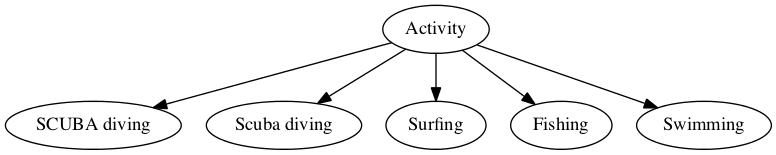

In [10]:
category, entropy = find_largest(entropy_results)
# creates a directed graph
g1 = gv.Digraph(format='png')
# creates the tree for the outlook category (since it is the one with the biggest information gain)
sub_tree(g1, category, entropy, None)
# saves the graph as a .png image in the img directory with name g1
filename = g1.render(filename='img/g1')
# displays the tree
Image("img/g1.png")

## The ID3 Algorithm

Now that we have all the utility functions we need, creating the ID3 algorithm is quite simple. We pass our graph object and all the information we require to call the previous methods. The `decision_tree` will call itself recursively for every node that has an entropy greater than 0. Notice that there is a need to create a new `DataFrame` for each recursive call. Each `DataFrame` will only contain the rows of the previous one that contains the value of the parent node (with the column where this value is located removed).

In [11]:
def decision_tree(graph, entropy_results, parent, df, target_name, pos_value, neg_value):
    """ Creates a decision tree recursively based on the ID3 algorithm. This version only supports a binary output
        in the data set. It returns a new tree that is directly inserted into the graph argument.
    """
    category, entropy = find_largest(entropy_results)
    sub_tree(graph, category, entropy, parent)
    
    for key, value in entropy.iteritems():
        if value[0] != 0:
            new_df = df[df[category] == key]
            new_target = get_target(new_df, target_name, pos_value)
            new_data_set_entropy = set_entropy(new_target)
            new_entropy_results = entropies(new_df.drop(target_name, 1), new_target, new_data_set_entropy)
            decision_tree(graph, new_entropy_results, key, new_df, target_name, pos_value, neg_value)
        else:
            if value[1] == 1:
                graph.node(pos_value)
                graph.edge(key, pos_value)
            else:
                graph.node(neg_value)
                graph.edge(key, neg_value)

Calling our final function will generate the complete decision tree for the dataset.

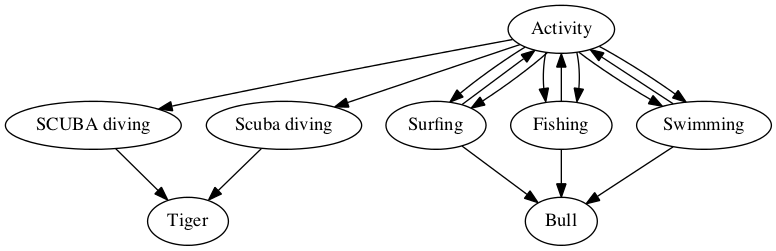

In [12]:
g1 = gv.Digraph(format='png')
decision_tree(g1, entropy_results, None, training_df, "Species", "Tiger", "Bull")
filename = g1.render(filename='img/g1')
Image("img/g1.png")

This tree is quite interesting; it appears that if an individual is scuba diving, it is likely that he could be attacked by a Tiger Shark. On the other hand, our data shows that Surfing, Fishing, and Swimming attacks are attributed more to Bull sharks than Tiger sharks.

Did you notice that the `country` feature is completely missing from the tree? This is due to _pruning_. Pruning is a technique that is employed by the ID3 algorithm, among several others, to reduce the complexity or depth of the resulting tree. In summary, while ID3 is iterating through the different features, it determines which sections of the tree provide little additional information and removes them. That is why we create the subtrees of the features with more information gain first, and as a result, we get less _overfitting_ in our predictions. For more information take a look at this article from [Wikipedia](https://en.wikipedia.org/wiki/Pruning_(decision_trees)).

## Summary of the ID3 Algorithm

Congratulations! You have a fully functional ID3 algorithm that will work on any data set given to it (with the restrictions specified above). Let's take an overall look at the algorithm:

1. Find the target entropy of the data set.
2. For every category, locate the entropy for each value it can have. For example: for `Sex`, `Feminine` and `Masculine`.
3. For every category, find the information gain using the entropy values calculated in step 2.
4. Find the largest information gain of the categories.
5. Create a sub-tree for that category (if it is the first one, it will become the root node of the tree).
6. For every node in that category:
    1. If it has an entropy of 0, point to the final decision node (positive or negative) depending on its `pos_value`.
    2. If the entropy is greater than 0:
        1. Create a new dataset that only contains the rows with the value of that node.
        2. Find the target values for the new data set.
        3. Repeat recursively from step 1.
        
And that's it! Thank you very much for following this tutorial.

## References

* Dr. Saed Sayad. Decision Tree - Classification. (2010-2016). _An Introduction to Data Mining_. Obtained from [source](http://www.saedsayad.com/decision_tree.htm).
* scikit-learn. Decision Trees. (2010-2016). _Machine Learning in Python_. Obtained from [source](http://scikit-learn.org/stable/modules/tree.html).
* David Ramos. Decision Trees and the Iterative Dictomizer Algorithm. (2006). Obtained from: www.cs.sjsu.edu/faculty/lee/cs157b/David_Ramos.ppt
* zel buenaobra. ID3 decision tree play baseball example. (2016). _YouTube_. Obtained from [source](https://www.youtube.com/watch?v=czPBoxmI7_I).
* Soetam Rizky. ID3 algorithm. (2011). _YouTube_. Obtained from [here](https://www.youtube.com/watch?v=wL9aogTuZw8).
* Tom Mitchell. (1997). Chapter 3, Decision Tree Learning. _Machine Learning_, McGraw Hill. Obtained from [source](http://web.arch.usyd.edu.au/~wpeng/DecisionTree2.pdf).
* Wei Peng, Juhua Chen and Haiping Zhou. An Implementation of ID3 - Decision Tree Learning Algorithm. _University of New South Wales, School of Computer Science & Engineering, Sydney, Australia_. Obtained from [source](http://web.arch.usyd.edu.au/~wpeng/DecisionTree2.pdf).
* Amro. (2009). What is "entropy and information gain"?. _Stackoverflow_. Obtained from [source](http://stackoverflow.com/questions/1859554/what-is-entropy-and-information-gain).